In [1]:
import gzip
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random

In [2]:
# If RELEASE_MODE is True, then:
#  - plot all data
#  - save figures as pdf

RELEASE_MODE = True
if "RELEASE_MODE" in os.environ and os.environ["RELEASE_MODE"] == "1":
    RELEASE_MODE = True
    

# If RELEASE_MODE is False, use a smaller sample. This makes tweaking charts faster/easier
def simplify_data(data):
    if RELEASE_MODE:
        return data
    else:
        num_samples = len(data) / 100
        sampled = []
        for (index, v) in enumerate(data):
            probability = (num_samples - len(sampled)) / (len(data) - index)
            if random.random() < probability:
                sampled.append(v)
        return sampled
        

In [3]:
with gzip.open("../../data/background/witness-size.json.gz") as f:
    witness_sizes = simplify_data(json.load(f))
    
with gzip.open("../../data/background/block-size.json.gz") as f:
    block_sizes = simplify_data(json.load(f))
    
with gzip.open("../../data/background/db-bytes.json.gz") as f:
    db_bytes = simplify_data(json.load(f))
    
with gzip.open("../../data/background/db-ops.json.gz") as f:
    db_ops = simplify_data(json.load(f))
    
with gzip.open("../../data/background/on-disk-size.json.gz") as f:
    on_disk_size = simplify_data(json.load(f))
    
with gzip.open("../../data/background/stateless-on-disk-size.json.gz") as f:
    stateless_on_disk_size = simplify_data(json.load(f))

# sometimes elapsed_milliseconds is negative so we filter that out
with gzip.open("../../data/background/db-ops-elapsed-1000.json.gz") as f:
    db_ops_elapsed = list(filter(lambda x: x[2] >= 0 and x[2] <= 1000000, simplify_data(json.load(f))))
    
with gzip.open("../../data/background/db-bytes-elapsed-1000.json.gz") as f:
    db_bytes_elapsed = list(filter(lambda x: x[2] >= 0 and x[2] <= 1000000, simplify_data(json.load(f))))
    



In [58]:
stateless_import_throughput = []
with open("../../data/background/stateless-import-3.log") as f:
    for line in f:
        split = line.split()
        if len(split) < 12:
            continue
        stateless_import_throughput.append(((int(split[3][1:])), float(split[5])))

stateful_import_throughput = []
with open("../../data/background/stateful-import-3.log") as f:
    for line in f:
        split = line.split()
        if len(split) < 12:
            continue
        stateful_import_throughput.append(((int(split[3][1:])), float(split[5])))
        


In [4]:
def plot_sizes(data, ax, title, ylabel, *, rolling=1):
    i = max(range(len(data)), key=lambda i: data[i][1])
    print("max size:", data[i])
    ax.margins(0.01)
    ax.scatter([x[0] for x in data], np.convolve([x[1] for x in data], np.ones((rolling,))/rolling, mode='same'), 
               s=1, rasterized=True)
    ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: str(int(x))))
    ax.tick_params(labelsize=14)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel("Block Number", fontsize=18)
    return ax

max size: [2806693, 718140]


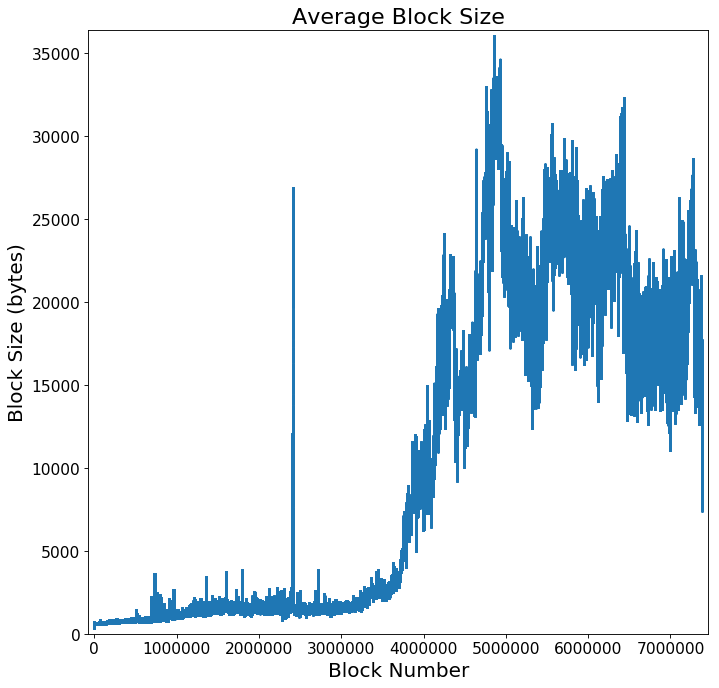

In [5]:
block_size_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = block_size_fig.add_subplot(1,1,1)
plot_sizes(block_sizes, ax, "Average Block Size", "Block Size (bytes)", rolling=2000)
ax.get_yaxis().set_major_locator(ticker.MultipleLocator(5000))

max size: (2306350, 46.926419258117676)


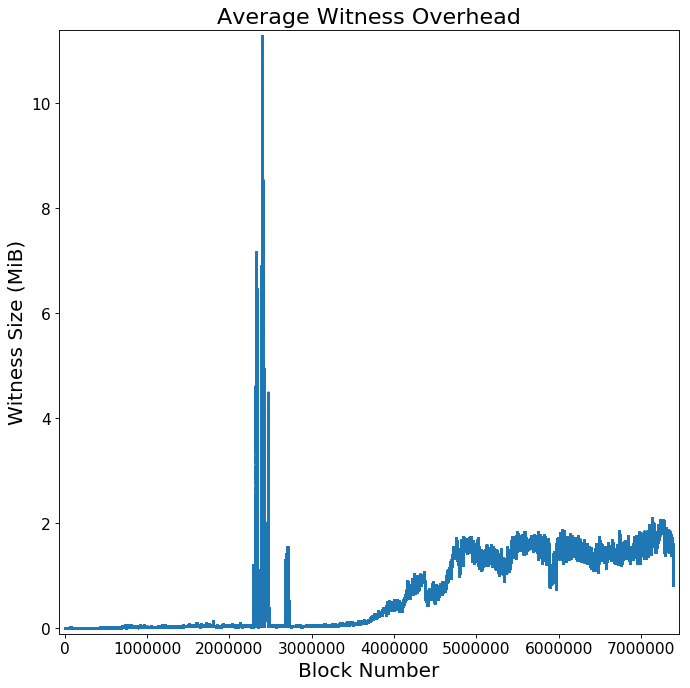

In [6]:
witness_size_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = witness_size_fig.add_subplot(1,1,1)
plot_sizes([(x[0], x[1] / (1024 * 1024)) for x in witness_sizes], ax, "Average Witness Overhead", "Witness Size (MiB)", rolling=2000)
# ax.get_yaxis().set_major_locator(ticker.MultipleLocator(2))

max size: (2283432, 7742879.936808847)


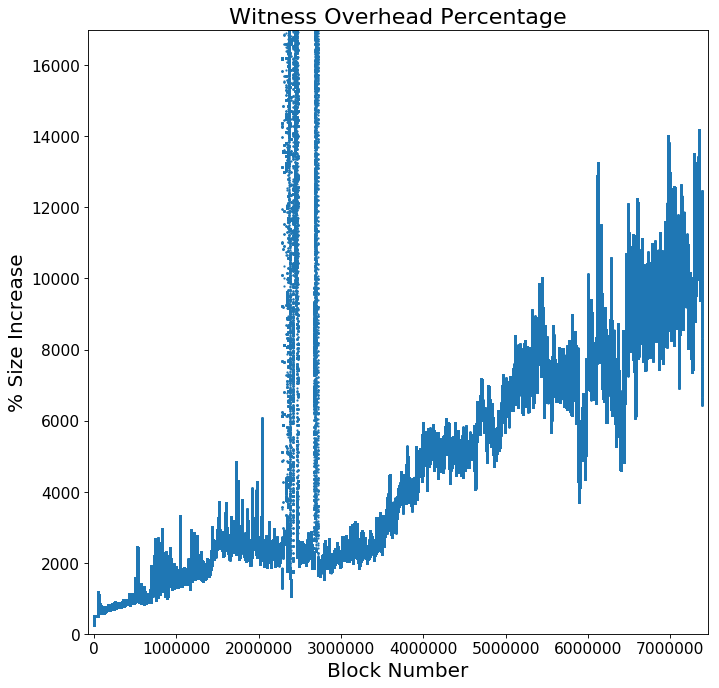

In [86]:
witness_block_size_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = witness_block_size_fig.add_subplot(1,1,1)
plot_sizes([(w[0], 100 * w[1] / block_sizes[i][1]) for (i, w) in enumerate(witness_sizes)], ax, "Witness Overhead As Percentage", "% Size Increase", rolling=2000)
ax.set_ylim(0, 17000)
ax

In [7]:
max_stateless_disk_size_block_num = max((s[0] for s in stateless_on_disk_size))
projected_stateless_disk_usage = []
projected_stateful_disk_usage = []

rate = None

block_number = None
ctmp = 0
for i, _ in enumerate(witness_sizes):
    witness_size = witness_sizes[i][1]
    block_size = block_sizes[i][1]
    if block_number is not None:
        assert witness_sizes[i][0] > block_number
    block_number = witness_sizes[i][0]
    assert block_number == block_sizes[i][0]
    
    ctmp += witness_size + block_size
    if block_number % 1000 == 0 and block_number >= max_stateless_disk_size_block_num:
        assert block_number == on_disk_size[(i) // 1000][0]
        real_on_disk_size = on_disk_size[(i) // 1000][1]
        state_size = real_on_disk_size - block_size
        projected_stateless_disk_usage.append([block_number, ctmp])
        projected_stateful_disk_usage.append([block_number, ctmp + state_size])
        
        # use last N entries to calculate rate
        block_range = 20
        if len(projected_stateful_disk_usage) >= block_range + 1:
            
            current_rate = (projected_stateful_disk_usage[-1][1] - projected_stateful_disk_usage[-1 - block_range][1]) /  \
                           (projected_stateful_disk_usage[-1][0] - projected_stateful_disk_usage[-1 - block_range][0])
            if rate is not None:
                rate = current_rate * 0.8 + rate * 0.2
            else:
                rate = current_rate

# 15 blocks created per second
ETHEREUM_BLOCK_CREATION_INTERVAL_SECONDS = 15

print("rate of growth: {} bytes / block, {} bytes / day".format(rate, rate * (86400 / 15)))


rate of growth: 1702850.345634737 bytes / block, 9808417990.856085 bytes / day


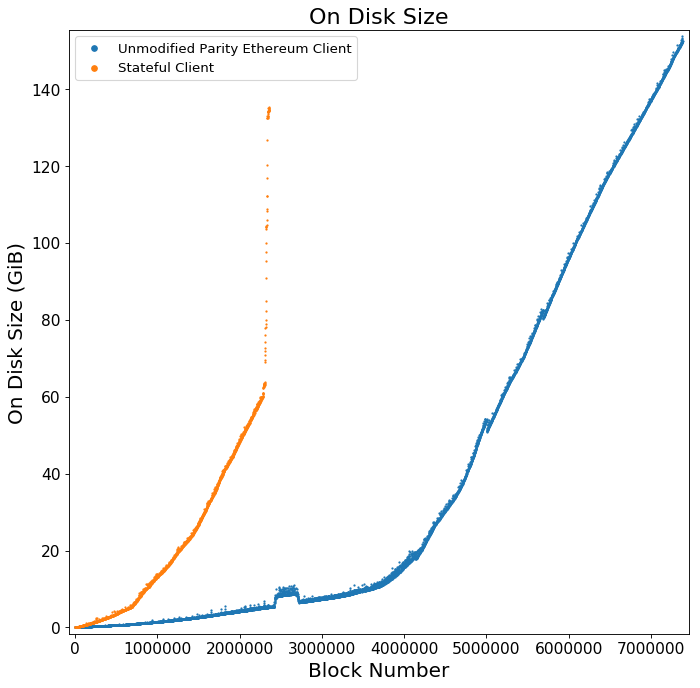

In [8]:
def plot_multiple_sizes(dataList, ax, title, ylabel, *, rolling=1):
    ax.margins(0.01)
    scatters = []
    for data in dataList:
        scatter = ax.scatter([x[0] for x in data[1]], np.convolve([x[1] for x in data[1]], np.ones((rolling,))/rolling, mode='same'), 
                       s=1, rasterized=True)
        scatters.append((data[0], scatter))
    ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: str(int(x))))
    ax.tick_params(labelsize=14)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel("Block Number", fontsize=18)
    ax.legend([s[1] for s in scatters], [s[0] for s in scatters], fontsize=12, markerscale=5)


    return ax

on_disk_size_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = on_disk_size_fig.add_subplot(1,1,1)

diff_disk_size = [(stateless_on_disk_size[i][0], stateless_on_disk_size[i][1] - on_disk_size[i][1]) for (i, _) in enumerate(stateless_on_disk_size)]
plot_multiple_sizes([["Unmodified Parity Ethereum Client", [(x[0], x[1] / (1024 * 1024 * 1024)) for x in on_disk_size]], 
                    ["Stateful Client", [(x[0], x[1] / (1024 * 1024 * 1024)) for x in stateless_on_disk_size]]], ax, "On Disk Size", "On Disk Size (GiB)", rolling=1)
# ax.get_yaxis().set_major_locator(ticker.MultipleLocator(2))

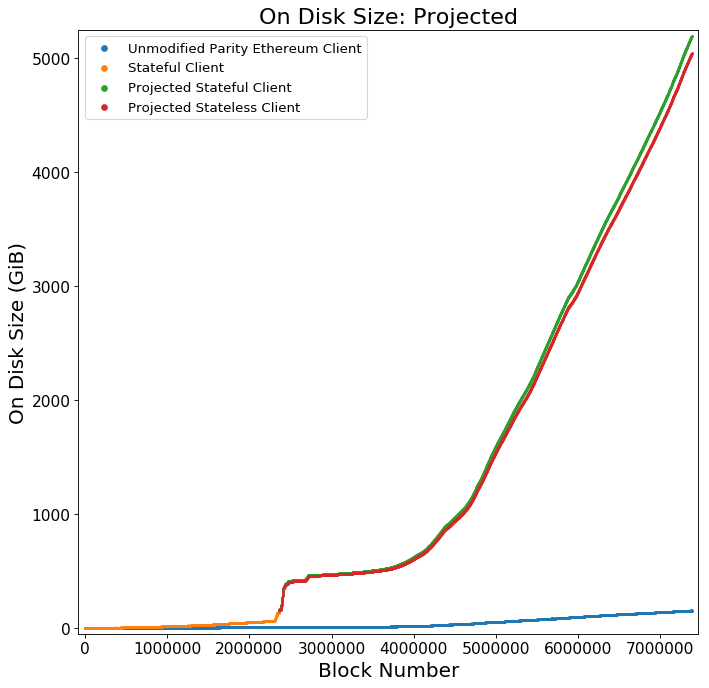

In [13]:
projected_on_disk_size_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = projected_on_disk_size_fig.add_subplot(1,1,1)

plot_multiple_sizes([["Unmodified Parity Ethereum Client", [(x[0], x[1] / (1024 * 1024 * 1024)) for x in on_disk_size]], 
                    ["Stateful Client", [(x[0], x[1] / (1024 * 1024 * 1024)) for x in stateless_on_disk_size]],
                    ["Projected Stateful Client", [(x[0], x[1] / (1024 * 1024 * 1024)) for x in projected_stateful_disk_usage]],
                    ["Projected Stateless Client", [(x[0], x[1] / (1024 * 1024 * 1024)) for x in projected_stateless_disk_usage]]], ax, "On Disk Size: Projected", "On Disk Size (GiB)", rolling=1)

In [14]:
def plot_db_stats(data, ax, title, ylabel, *, rolling=1):
    ax.margins(0.01)
    read_scatter = ax.scatter([x[0] for x in data], 
                              np.convolve([x[1] for x in data], np.ones((rolling,))/rolling, mode='same'),
                              s=1, rasterized=True)
    write_scatter = ax.scatter([x[0] for x in data], 
                               np.convolve([x[2] for x in data], np.ones((rolling,))/rolling, mode='same'),
                               s=1, rasterized=True)
    delete_scatter = ax.scatter([x[0] for x in data], 
                                np.convolve([x[3] for x in data], np.ones((rolling,))/rolling, mode='same'),
                                s=1, rasterized=True)
    ax.legend((read_scatter, write_scatter, delete_scatter), ("Read", "Write", "Delete"), fontsize=12, markerscale=5)
    ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: str(int(x))))
    ax.tick_params(labelsize=12)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel("Block Number", fontsize=16)
    return ax

In [15]:
db_io_bytes_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = db_io_bytes_fig.add_subplot(1, 1, 1)
plot_db_stats([[x[0], x[1] / (1024 * 1024), x[2] / (1024 * 1024), x[3] / (1024 * 1024)] for x in db_bytes], ax, "Database I/O", "I/O (MiB)", rolling=200)

Error in callback <function flush_figures at 0x7f29c0ea4268> (for post_execute):


KeyboardInterrupt: 

KeyboardInterrupt: 

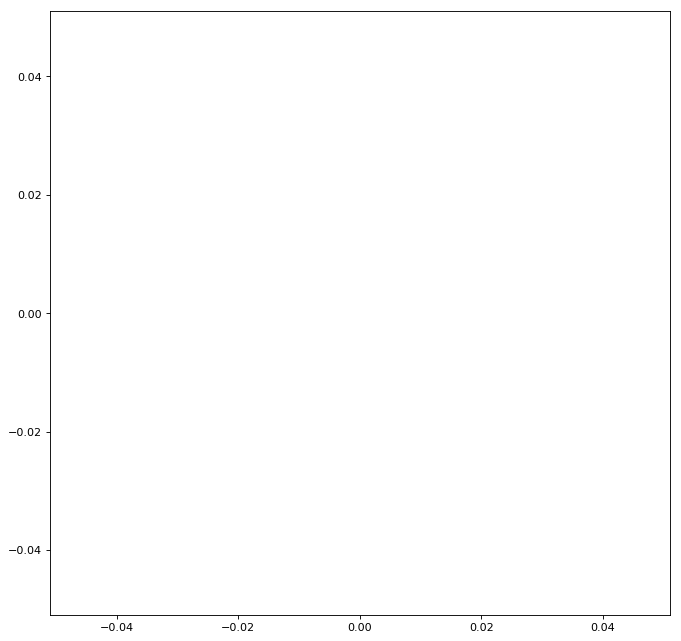

In [16]:
db_io_ops_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = db_io_ops_fig.add_subplot(1, 1, 1)
plot_db_stats(db_ops, ax, "Database I/O Operations", "Number of Operations", rolling=200)
ax.get_yaxis().set_major_locator(ticker.MultipleLocator(10000))

In [27]:
def plot_db_elapsed_stats(data, ax, title, ylabel):
    ax.margins(0.01)
    # tuple is in the following format: (start_block_num, end_block_num, elapsed_milliseconds, reads, writes, deletes)
    read_scatter = ax.scatter([x[2] / 1000 for x in data], 
                              [x[3] / 1000 for x in data],
                              s=1, rasterized=True)
    write_scatter = ax.scatter([x[2] / 1000 for x in data], 
                               [(x[4] + x[5]) / 1000 for x in data],
                               s=1, rasterized=True)
    ax.legend((read_scatter, write_scatter), ("Read", "Write"), fontsize=12, markerscale=5)
    #ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: str(int(x))))
    ax.tick_params(labelsize=12)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel("Block Verification Time (ms)", fontsize=16)
    return ax

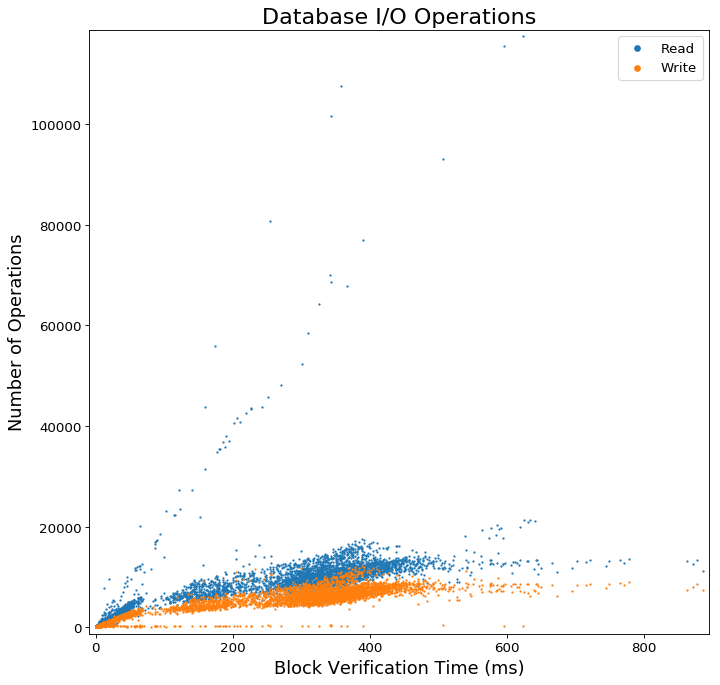

In [28]:
db_io_ops_elapsed_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = db_io_ops_elapsed_fig.add_subplot(1, 1, 1)
plot_db_elapsed_stats(db_ops_elapsed, ax, "Database I/O Operations", "Number of Operations")

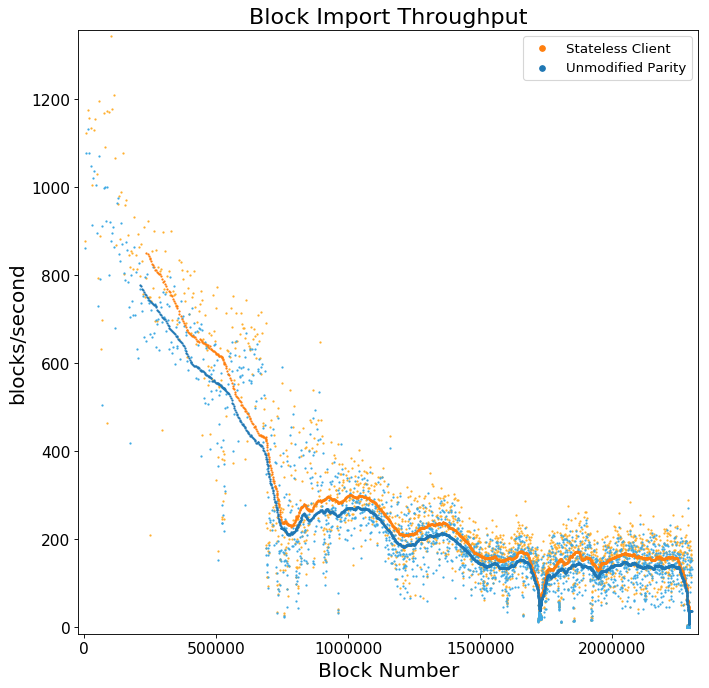

In [98]:
def plot_throughput(dataList, ax, title, ylabel, xlimit, *, rolling=1):
    ax.margins(0.01)
    scatters = []
    for data in dataList:
        ypoints = [x[1] for x in data[1]]
        points = list(filter(lambda p: p[0] < xlimit, zip([x[0] for x in data[1]], ypoints)))
        scatter = ax.scatter([p[0] for p in points], [p[1] for p in points], 
                       s=1, rasterized=True, color=data[3])
        
    for data in dataList:
        ypoints = np.convolve([x[1] for x in data[1]], np.ones((rolling,))/rolling, mode="valid")
        x_offset = (len(data[1]) - len(ypoints)) // 2
        points = list(filter(lambda p: p[0] < xlimit, zip([x[0] for x in data[1][x_offset:][:-x_offset]], ypoints)))
        scatter = ax.scatter([p[0] for p in points], [p[1] for p in points], 
                       s=1, rasterized=True, color=data[2])
        scatters.append((data[0], scatter))
    ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: str(int(x))))
    ax.tick_params(labelsize=14)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel("Block Number", fontsize=18)
    ax.legend([s[1] for s in scatters], [s[0] for s in scatters], fontsize=12, markerscale=5)


    return ax

throughput_fig = plt.figure(figsize=(10, 10), dpi=80)
ax = throughput_fig.add_subplot(1, 1, 1)
plot_throughput([["Stateless Client", stateless_import_throughput, "#ff7f0e", "#ffaf2f"], 
                    ["Unmodified Parity", stateful_import_throughput, "#1f77b4", "#3faae4"]], ax, "Block Import Throughput", "blocks/second", 2300000, rolling=100)



In [ ]:
if RELEASE_MODE:
    block_size_fig.savefig("block-size.pdf", transparent=False)
    witness_size_fig.savefig("witness-size.pdf", transparent=False)
    db_io_bytes_fig.savefig("db-io-bytes.pdf", transparent=False)
    db_io_ops_fig.savefig("db-io-ops.pdf", transparent=False)
    on_disk_size_fig.savefig("on-disk-size.pdf", transparent=False)
    projected_on_disk_size_fig.savefig("projected-on-disk-size.pdf", transparent=False)
    db_io_ops_elapsed_fig.savefig("db-io-ops-elapsed.pdf", transparent=False)
    throughput_fig.savefig("throughput.pdf", transparent=False)
    witness_block_size_fig.savefig("witness-block-size.pdf", transparent=False)

In [30]:
db_io_ops_elapsed_fig.savefig("db-io-ops-elapsed.pdf", transparent=False)

In [99]:
throughput_fig.savefig("throughput.pdf", transparent=False)

In [100]:
witness_block_size_fig.savefig("witness-block-size.pdf", transparent=False)